In [0]:
from keras.datasets import mnist
from keras.layers import *
from keras.models import Sequential ,Model   ## Model is functional api
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
(X_train,_),(_ ,_)=mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
X_train.shape

(60000, 28, 28)

In [0]:
type(X_train)

numpy.ndarray

In [0]:
print(X_train.shape)
print(type(X_train))

X_train=X_train.reshape(*X_train.shape,1)
print(X_train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)


In [0]:
## normalize this data in range [-1,1]
X_train=(X_train.astype('float32')-127.5)/127.5
print(np.min(X_train))
print(np.max(X_train))

-1.0
1.0


In [0]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_train.shape[0]/(BATCH_SIZE))
HALF_BATCH_SIZE = int(BATCH_SIZE/2)  # 128 fake images and 128 real images

NOISE_DIM = 100   ## upsample to 784 dimensional vector

adam = Adam(lr=2e-4,beta_1=0.5)

In [0]:
#Upsampling 
## defining the generator
# Start from 7 X 7 X 128
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,))) # it is a 7*7*128 linear noise vector
generator.add(Reshape((7,7,128)))     # 3d noise vector
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#Double the Activation Size to 14 X 14 X 64
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double the Activation Size to 28 X 28 X 1
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

# Final Output (No ReLu or Batch Norm)
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
__________________

In [0]:
#Discriminator - Downsampling
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Prefer Strided Convolutions over MaxPooling (14x14x64)--->(7x7x128)
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))


discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [0]:
## first generator will br frozen and we train dicriminator
## then reverse

## step-2
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

#Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [0]:
def save_imgs(epoch,samples=100):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()

In [0]:
!mkdir images

In [0]:
!mkdir models

In [0]:
!ls

images	models	sample_data


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Disc loss: 0.6855 Generator loss: 0.877472
Epoch 2 Disc loss: 0.6923 Generator loss: 0.832511
Epoch 3 Disc loss: 0.6845 Generator loss: 0.843055
Epoch 4 Disc loss: 0.6883 Generator loss: 0.827249
Epoch 5 Disc loss: 0.6902 Generator loss: 0.812523


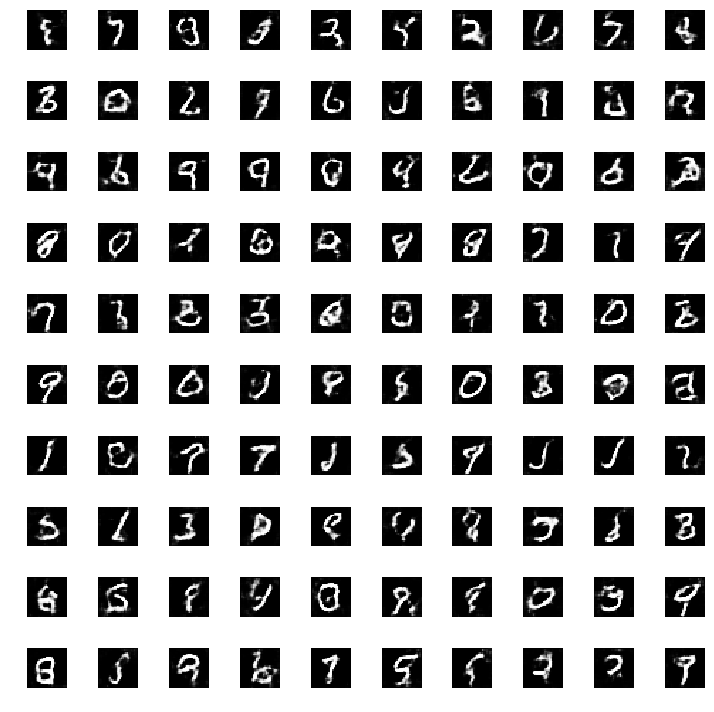

Epoch 6 Disc loss: 0.6895 Generator loss: 0.812419
Epoch 7 Disc loss: 0.6890 Generator loss: 0.816606
Epoch 8 Disc loss: 0.6886 Generator loss: 0.815621
Epoch 9 Disc loss: 0.6881 Generator loss: 0.817600
Epoch 10 Disc loss: 0.6877 Generator loss: 0.816181


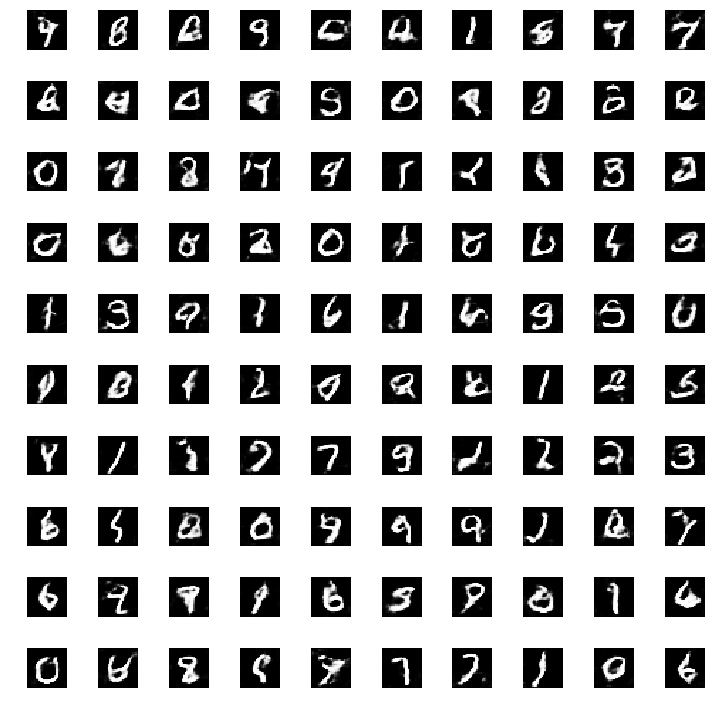

Epoch 11 Disc loss: 0.6871 Generator loss: 0.820726
Epoch 12 Disc loss: 0.6871 Generator loss: 0.820514
Epoch 13 Disc loss: 0.6868 Generator loss: 0.818244
Epoch 14 Disc loss: 0.6862 Generator loss: 0.821840
Epoch 15 Disc loss: 0.6859 Generator loss: 0.824095


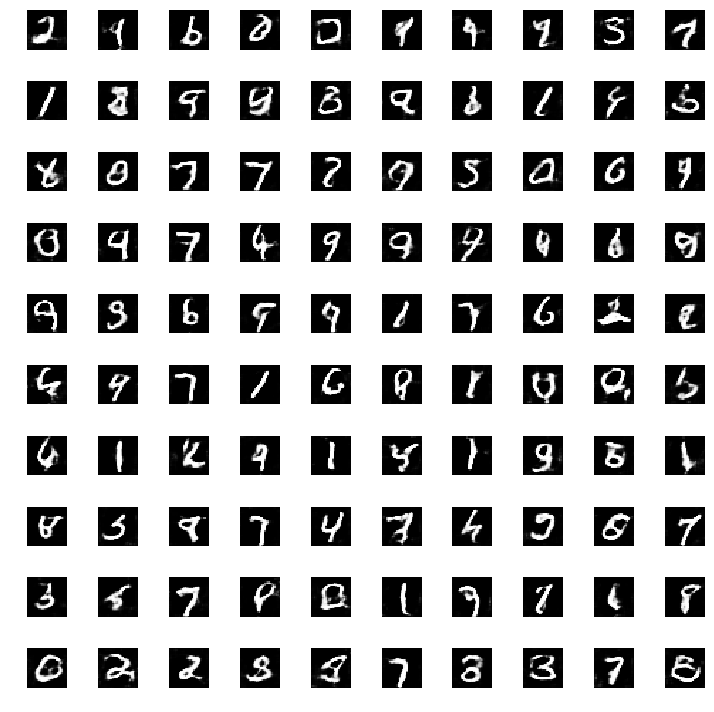

Epoch 16 Disc loss: 0.6852 Generator loss: 0.826462
Epoch 17 Disc loss: 0.6850 Generator loss: 0.823863
Epoch 18 Disc loss: 0.6842 Generator loss: 0.832617
Epoch 19 Disc loss: 0.6835 Generator loss: 0.831135
Epoch 20 Disc loss: 0.6832 Generator loss: 0.834123


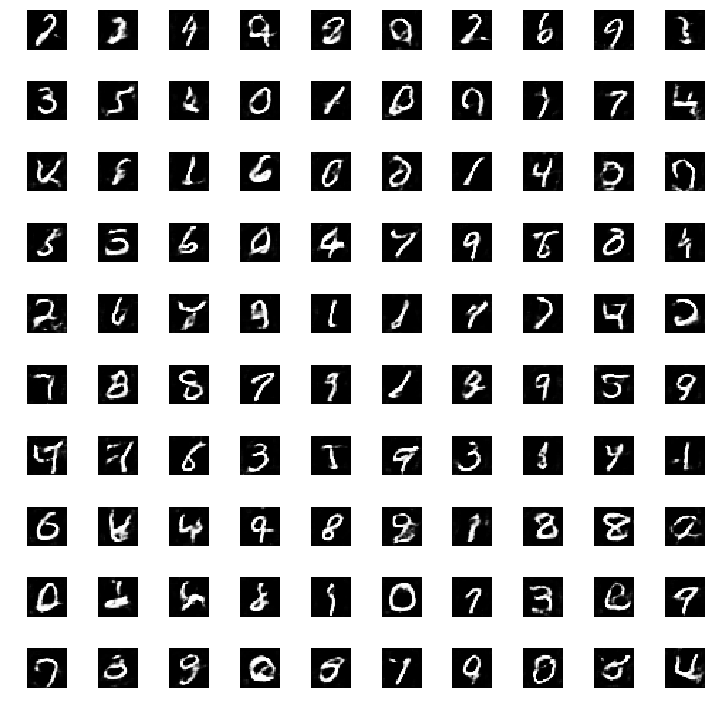

Epoch 21 Disc loss: 0.6826 Generator loss: 0.834428
Epoch 22 Disc loss: 0.6825 Generator loss: 0.833261
Epoch 23 Disc loss: 0.6808 Generator loss: 0.844556
Epoch 24 Disc loss: 0.6811 Generator loss: 0.835868
Epoch 25 Disc loss: 0.6806 Generator loss: 0.838907


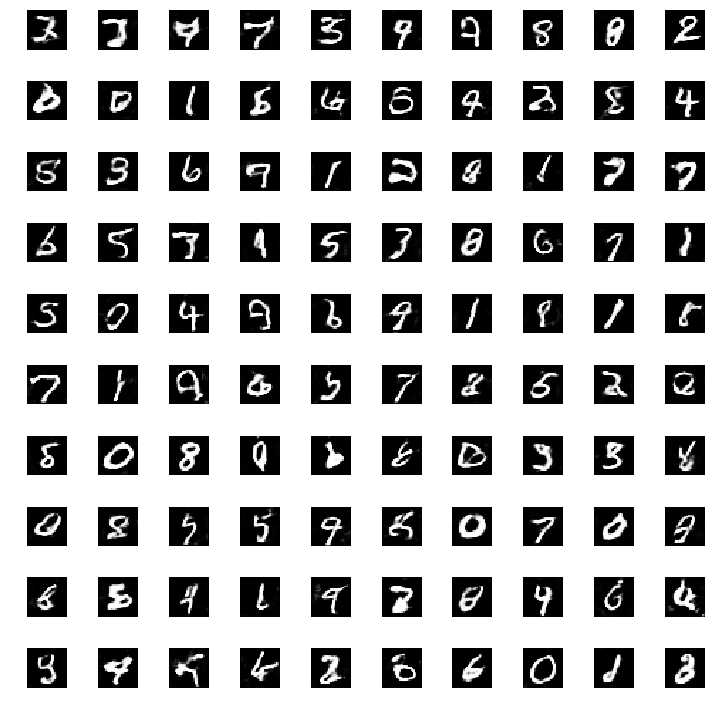

Epoch 26 Disc loss: 0.6782 Generator loss: 0.863098
Epoch 27 Disc loss: 0.6788 Generator loss: 0.844491
Epoch 28 Disc loss: 0.6787 Generator loss: 0.846502
Epoch 29 Disc loss: 0.6780 Generator loss: 0.850208
Epoch 30 Disc loss: 0.6769 Generator loss: 0.856984


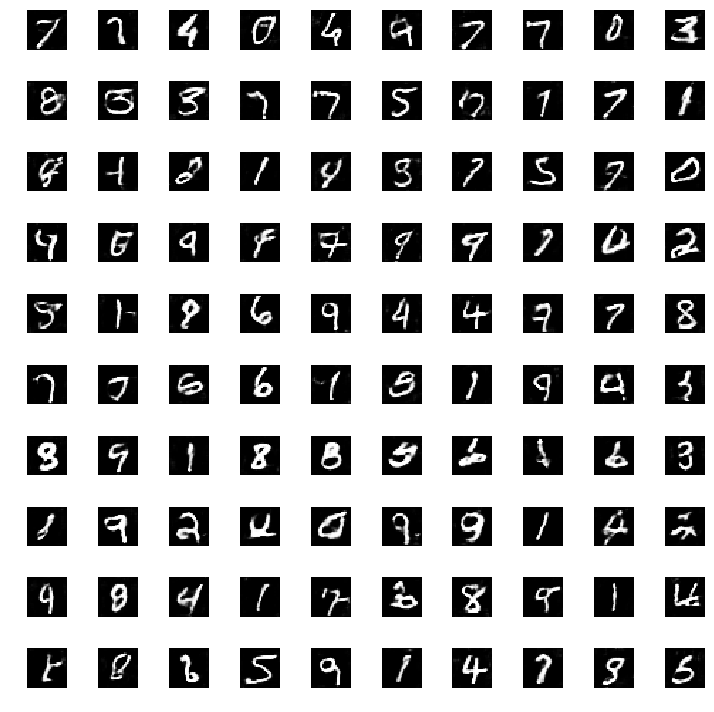

Epoch 31 Disc loss: 0.6764 Generator loss: 0.855931
Epoch 32 Disc loss: 0.6762 Generator loss: 0.863538
Epoch 33 Disc loss: 0.6752 Generator loss: 0.862248
Epoch 34 Disc loss: 0.6742 Generator loss: 0.870866
Epoch 35 Disc loss: 0.6741 Generator loss: 0.870290


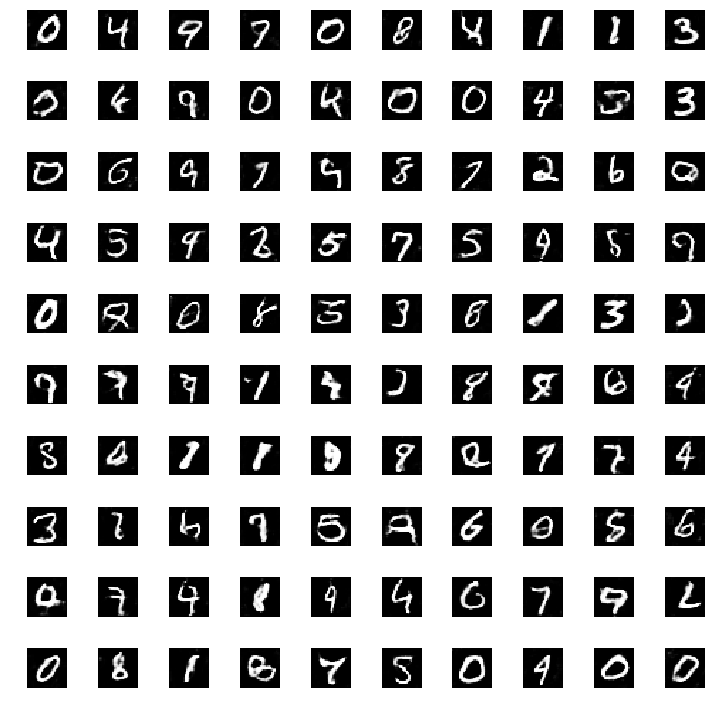

Epoch 36 Disc loss: 0.6735 Generator loss: 0.869260
Epoch 37 Disc loss: 0.6715 Generator loss: 0.885909
Epoch 38 Disc loss: 0.6711 Generator loss: 0.877267
Epoch 39 Disc loss: 0.6706 Generator loss: 0.881887
Epoch 40 Disc loss: 0.6694 Generator loss: 0.885775


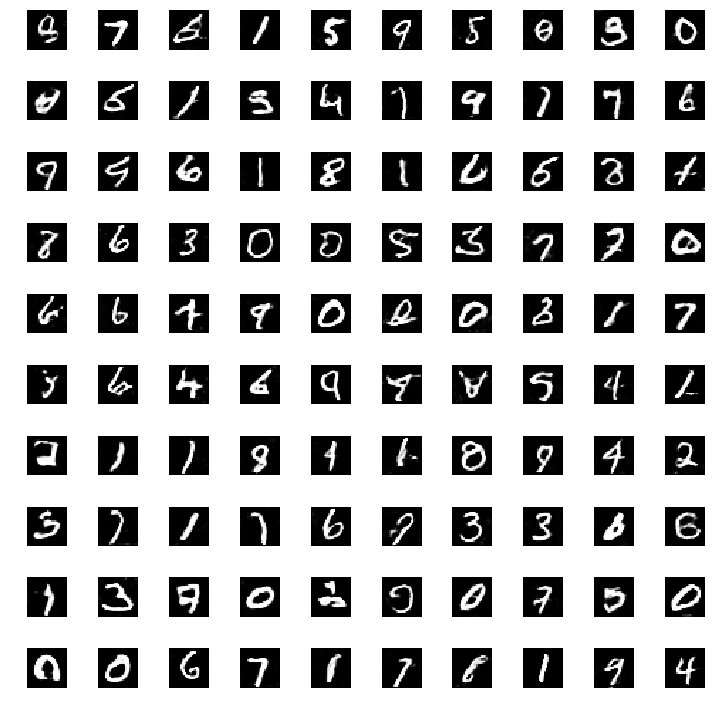

Epoch 41 Disc loss: 0.6685 Generator loss: 0.889819
Epoch 42 Disc loss: 0.6680 Generator loss: 0.894172
Epoch 43 Disc loss: 0.6672 Generator loss: 0.897464
Epoch 44 Disc loss: 0.6664 Generator loss: 0.900391
Epoch 45 Disc loss: 0.6656 Generator loss: 0.905293


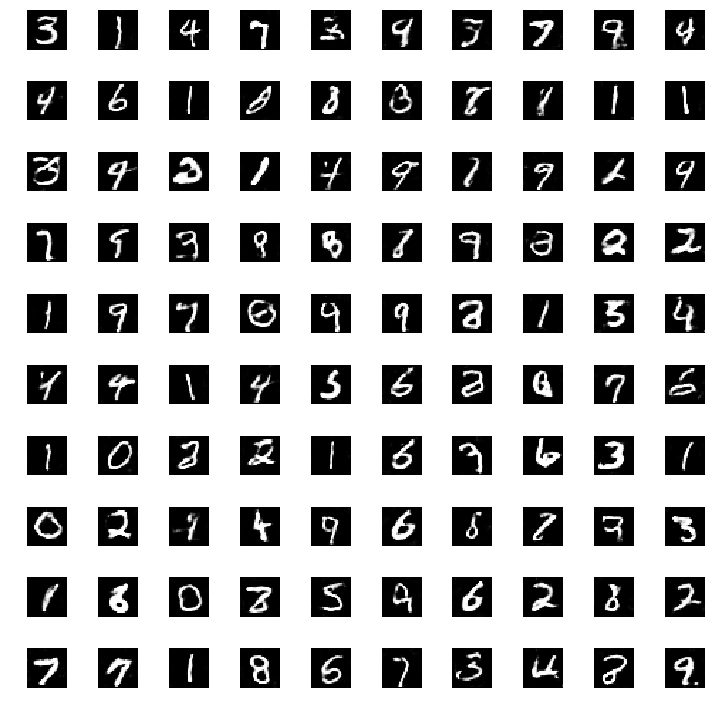

Epoch 46 Disc loss: 0.6636 Generator loss: 0.910469
Epoch 47 Disc loss: 0.6636 Generator loss: 0.918339
Epoch 48 Disc loss: 0.6622 Generator loss: 0.916684
Epoch 49 Disc loss: 0.6604 Generator loss: 0.929702
Epoch 50 Disc loss: 0.6586 Generator loss: 0.926308


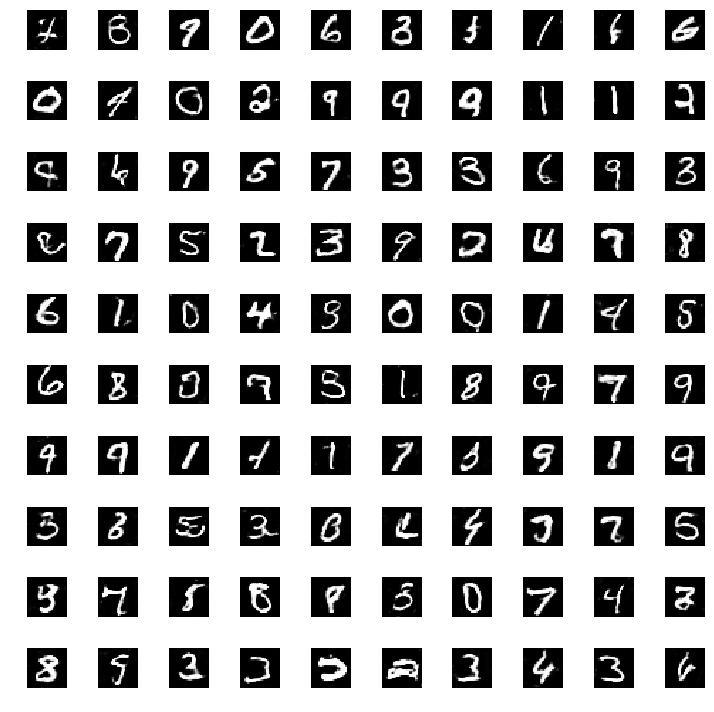

In [0]:
d_losses=[]
g_losses=[]
## Training Loop
for epoch in range(NUM_EPOCHS):
  epoch_d_loss=0.   # discriminator loss
  epoch_g_loss=0.   # generator loss
  
  # mini batch SGD
  
  for step in range(NO_OF_BATCHES):
    
    ##step-1 Discriminator#########################
    
    # 50% Real Data + 50% Fake Data
    
    # Real data X
    idx = np.random.randint(0,X_train.shape[0],HALF_BATCH_SIZE)
    real_imgs = X_train[idx]
    
    # Fake data X
    noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM))
    fake_imgs= generator.predict(noise) # forward
    
    
    # labels
    real_y = np.ones((HALF_BATCH_SIZE,1))*0.9  # one sided label smoothing
    fake_y = np.zeros((HALF_BATCH_SIZE,1))
    
    # Train our discriminator
    
    d_loss_real = discriminator.train_on_batch(real_imgs,real_y)  ## train_on_batch returns loss
    d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
    
    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
    
    epoch_d_loss += d_loss
    
    ## step-2 train generator  (consedering Frozen discriminator)#############   
    noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE,1))
    g_loss= model.train_on_batch(noise,ground_truth_y) ## includes both generator and discriminator
    
    epoch_g_loss +=g_loss
    
  print("Epoch %d Disc loss: %.4f Generator loss: %f" % ((epoch + 1), epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
  d_losses.append(epoch_d_loss/NO_OF_BATCHES)
  g_losses.append(epoch_g_loss/NO_OF_BATCHES)
  if (epoch+1)%5==0:
       generator.save('models/gan_generator_{0}.h5'.format(epoch+1))
       save_imgs(epoch)
    
    
    


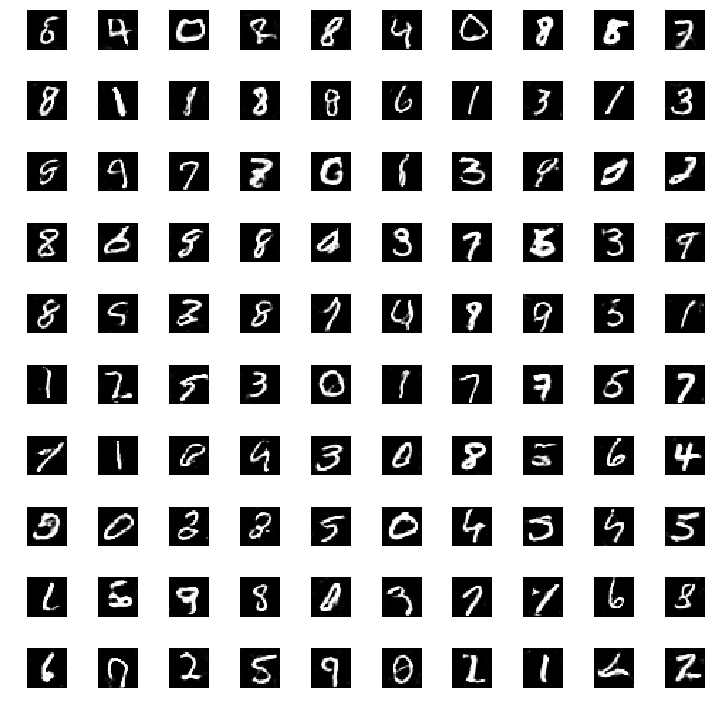

In [0]:
save_imgs(50)